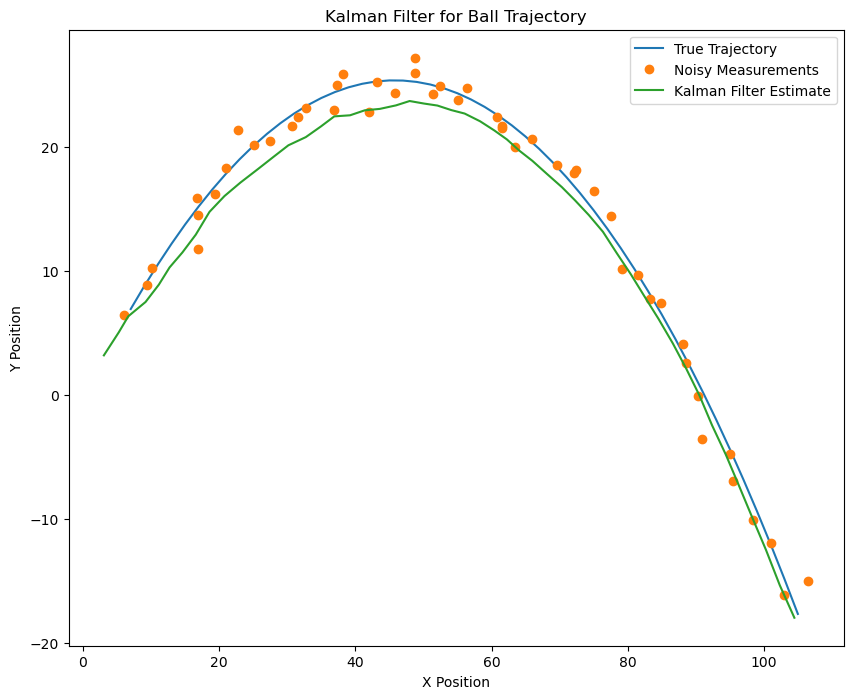

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, dt, u, std_acc, x_std_meas, y_std_meas):
        """
        Initializes the Kalman Filter.
        :param dt: time step
        :param u: control input (acceleration)
        :param std_acc: process noise standard deviation
        :param x_std_meas: measurement noise standard deviation for x
        :param y_std_meas: measurement noise standard deviation for y
        """
        self.dt = dt
        self.u = u  # No need to reshape u here, will handle it in predict
        self.std_acc = std_acc
        self.x_std_meas = x_std_meas
        self.y_std_meas = y_std_meas

        # State vector [x, y, vx, vy]
        self.x = np.zeros((4, 1))

        # State transition matrix
        self.F = np.array([[1, 0, self.dt, 0],
                           [0, 1, 0, self.dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])

        # Control input matrix
        self.B = np.array([[0.5 * self.dt ** 2, 0],
                           [0, 0.5 * self.dt ** 2],
                           [self.dt, 0],
                           [0, self.dt]])

        # Measurement matrix
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

        # Process noise covariance
        self.Q = np.array([[self.dt ** 4 / 4, 0, self.dt ** 3 / 2, 0],
                           [0, self.dt ** 4 / 4, 0, self.dt ** 3 / 2],
                           [self.dt ** 3 / 2, 0, self.dt ** 2, 0],
                           [0, self.dt ** 3 / 2, 0, self.dt ** 2]]) * std_acc ** 2

        # Measurement noise covariance
        self.R = np.array([[x_std_meas ** 2, 0],
                           [0, y_std_meas ** 2]])

        # Error covariance
        self.P = np.eye(4)

    def predict(self):
        # Predict the state and the error covariance
        self.x = np.dot(self.F, self.x) + np.dot(self.B, self.u.reshape(2, 1))
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        # Kalman Gain
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

        # Update the state
        y = z.reshape(2, 1) - np.dot(self.H, self.x)
        self.x = self.x + np.dot(K, y)

        # Update the error covariance
        I = np.eye(4)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

    def simulate(self, z):
        estimates = []
        for measurement in z:
            self.predict()
            self.update(measurement)
            estimates.append(self.x.copy())
        return np.array(estimates).squeeze()

def simulate_ball_trajectory(dt, total_time, initial_pos, initial_vel, acc):
    """
    Simulates the ball trajectory with given initial conditions and acceleration.
    """
    num_steps = int(total_time / dt)
    trajectory = np.zeros((num_steps, 2))
    vel = initial_vel
    pos = initial_pos

    for i in range(num_steps):
        pos = pos + vel * dt + 0.5 * acc * dt ** 2
        vel = vel + acc * dt
        trajectory[i] = pos
    return trajectory

def add_measurement_noise(trajectory, noise_std):
    """
    Adds measurement noise to the trajectory.
    """
    noisy_trajectory = trajectory + np.random.normal(0, noise_std, trajectory.shape)
    return noisy_trajectory

# Simulation parameters
dt = 0.1
total_time = 5
initial_pos = np.array([5, 5])
initial_vel = np.array([20, 20])
acc = np.array([0, -9.81])
measurement_noise_std = 1.0

# Simulate true trajectory
true_trajectory = simulate_ball_trajectory(dt, total_time, initial_pos, initial_vel, acc)

# Add measurement noise
noisy_measurements = add_measurement_noise(true_trajectory, measurement_noise_std)

# Kalman Filter parameters
kf = KalmanFilter(dt, acc, std_acc=0.1, x_std_meas=measurement_noise_std, y_std_meas=measurement_noise_std)

# Run the Kalman Filter
estimates = kf.simulate(noisy_measurements)

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], label='True Trajectory')
plt.plot(noisy_measurements[:, 0], noisy_measurements[:, 1], 'o', label='Noisy Measurements')
plt.plot(estimates[:, 0], estimates[:, 1], label='Kalman Filter Estimate')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Kalman Filter for Ball Trajectory')
plt.legend()
plt.show()
